In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from tqdm import tqdm
import random

In [2]:
df = pd.read_csv("train_dev_complete.csv")
df

,file,speaker,emotion,source,split
0,EMOITA/data/1613671614352.wav,emoita_321,anger,emoita,train
1,EMOITA/data/1613658275427.wav,emoita_303,anger,emoita,train
2,EMOITA/data/1613324357435.wav,emoita_314,anger,emoita,train
3,EMOITA/data/1614274086698.wav,emoita_109,anger,emoita,train
4,EMOITA/data/1612982146424.wav,emoita_179,anger,emoita,train
...,...,...,...,...,...
10673,TESS/data/OAF_cab_neutral.wav,tess_OAF,neutral,tess,train
10674,TESS/data/OAF_chain_disgust.wav,tess_OAF,disgust,tess,train
10675,TESS/data/OAF_jar_neutral.wav,tess_OAF,neutral,tess,train
10676,TESS/data/OAF_lot_angry.wav,tess_OAF,anger,tess,train


In [3]:
df["language"] = df.source.apply(lambda x: "italian" if x in ["emoita"] else "english")
df

,file,speaker,emotion,source,split,language
0,EMOITA/data/1613671614352.wav,emoita_321,anger,emoita,train,italian
1,EMOITA/data/1613658275427.wav,emoita_303,anger,emoita,train,italian
2,EMOITA/data/1613324357435.wav,emoita_314,anger,emoita,train,italian
3,EMOITA/data/1614274086698.wav,emoita_109,anger,emoita,train,italian
4,EMOITA/data/1612982146424.wav,emoita_179,anger,emoita,train,italian
...,...,...,...,...,...,...
10673,TESS/data/OAF_cab_neutral.wav,tess_OAF,neutral,tess,train,english
10674,TESS/data/OAF_chain_disgust.wav,tess_OAF,disgust,tess,train,english
10675,TESS/data/OAF_jar_neutral.wav,tess_OAF,neutral,tess,train,english
10676,TESS/data/OAF_lot_angry.wav,tess_OAF,anger,tess,train,english


## EDA

In [9]:
# class distribution table across splits
raw_table = pd.crosstab(
        index=df['split'], 
        columns=df['emotion']
    )
print("Raw counts: \n", raw_table)
print("\n\n")
percent_table = pd.crosstab(
        index=df['split'], 
        columns=df['emotion'], 
        normalize='index'
    ).round(3) * 100
print("Percentages: \n", percent_table)

Raw counts: 
 emotion  anger  disgust  fear  happiness  neutral  sadness  surprise
split                                                               
dev        321      288   308        316      295      333       297
train     1252     1137  1259       1281     1202     1245      1144



Percentages: 
 emotion  anger  disgust  fear  happiness  neutral  sadness  surprise
split                                                               
dev       14.9     13.3  14.3       14.6     13.7     15.4      13.8
train     14.7     13.3  14.8       15.0     14.1     14.6      13.4


In [10]:
# class distribution table across languages
raw_table = pd.crosstab(
        index=df['language'], 
        columns=df['emotion']
    )
print("Raw counts: \n", raw_table)
print("\n\n")
percent_table = pd.crosstab(
        index=df['language'], 
        columns=df['emotion'], 
        normalize='index'
    ).round(3) * 100
print("Percentages: \n", percent_table)

Raw counts: 
 emotion   anger  disgust  fear  happiness  neutral  sadness  surprise
language                                                             
english     772      620   772        772      676      772       620
italian     801      805   795        825      821      806       821



Percentages: 
 emotion   anger  disgust  fear  happiness  neutral  sadness  surprise
language                                                             
english    15.4     12.4  15.4       15.4     13.5     15.4      12.4
italian    14.1     14.2  14.0       14.5     14.5     14.2      14.5


In [11]:
# duration of each audio file in seconds
def get_duration(file_path):
    
    try:
        return librosa.get_duration(path = file_path, sr = 16000)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

df['duration'] = df['file'].apply(get_duration)
df[['file', 'duration']]

,file,duration
0,EMOITA/data/1613671614352.wav,1.509313
1,EMOITA/data/1613658275427.wav,3.390125
2,EMOITA/data/1613324357435.wav,1.811187
3,EMOITA/data/1614274086698.wav,3.030187
4,EMOITA/data/1612982146424.wav,2.421937
...,...,...
10673,TESS/data/OAF_cab_neutral.wav,1.906939
10674,TESS/data/OAF_chain_disgust.wav,2.349922
10675,TESS/data/OAF_jar_neutral.wav,2.056279
10676,TESS/data/OAF_lot_angry.wav,1.612640


In [12]:
df.duration.describe()

count    10678.000000
mean         3.113926
std          1.080072
min          0.754687
25%          2.214351
50%          3.010006
75%          3.819688
max         13.873938
Name: duration, dtype: float64

#### Energy (RMS) := Root Mean Square

In [13]:
def calculate_energy(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        rms = librosa.feature.rms(y=y)
        energy = np.mean(rms)
        return energy
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan
    
df['energy'] = df['file'].apply(calculate_energy)
df.energy.isna().any()

np.False_

([0, 1, 2, 3],
 [Text(0, 0, 'emoita'),
  Text(1, 0, 'ravdess'),
  Text(2, 0, 'savee'),
  Text(3, 0, 'tess')])

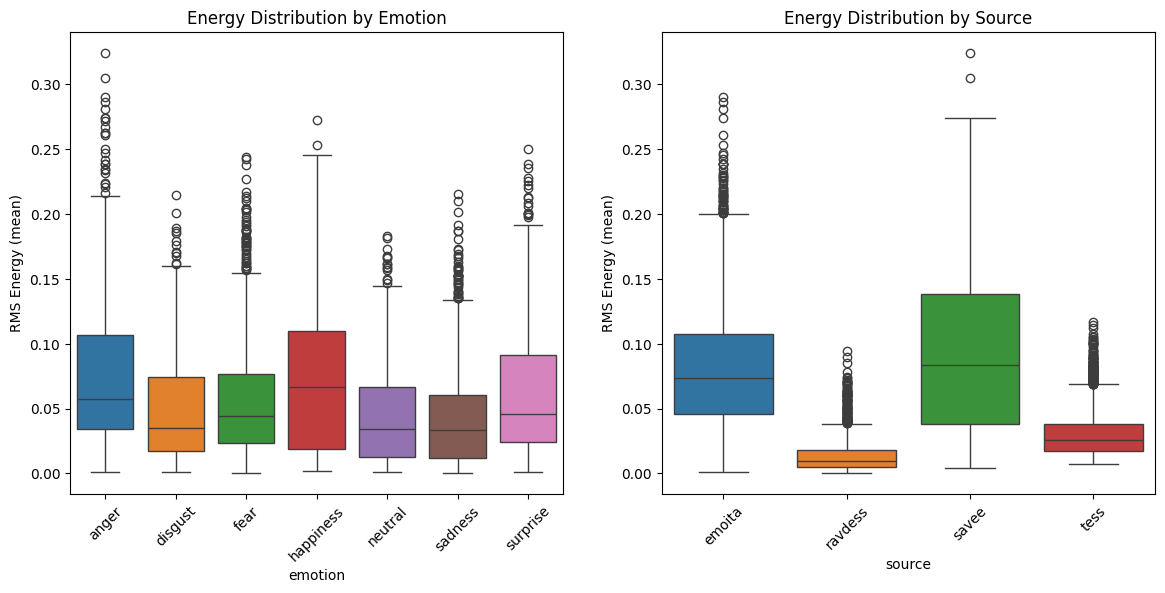

In [14]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='emotion', y='energy', data=df, hue='emotion')
plt.title('Energy Distribution by Emotion')
plt.ylabel('RMS Energy (mean)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='source', y='energy', data=df, hue='source')
plt.title('Energy Distribution by Source')
plt.ylabel('RMS Energy (mean)')
plt.xticks(rotation=45)


In [15]:
df.energy.describe()

count    10678.000000
mean         0.056922
std          0.046456
min          0.000371
25%          0.020007
50%          0.043574
75%          0.083625
max          0.324022
Name: energy, dtype: float64

L'energia per quanto riguarda le emozioni andrebbe anche bene, però se guardiamo per source, si nota che in particolare c'è una differenza sostanziale, questo potrebbe portare ad imparare la differenza tra dataset piuttosto che la differenza tra emozioni. Quindi bisogna normalizzare l'energia:

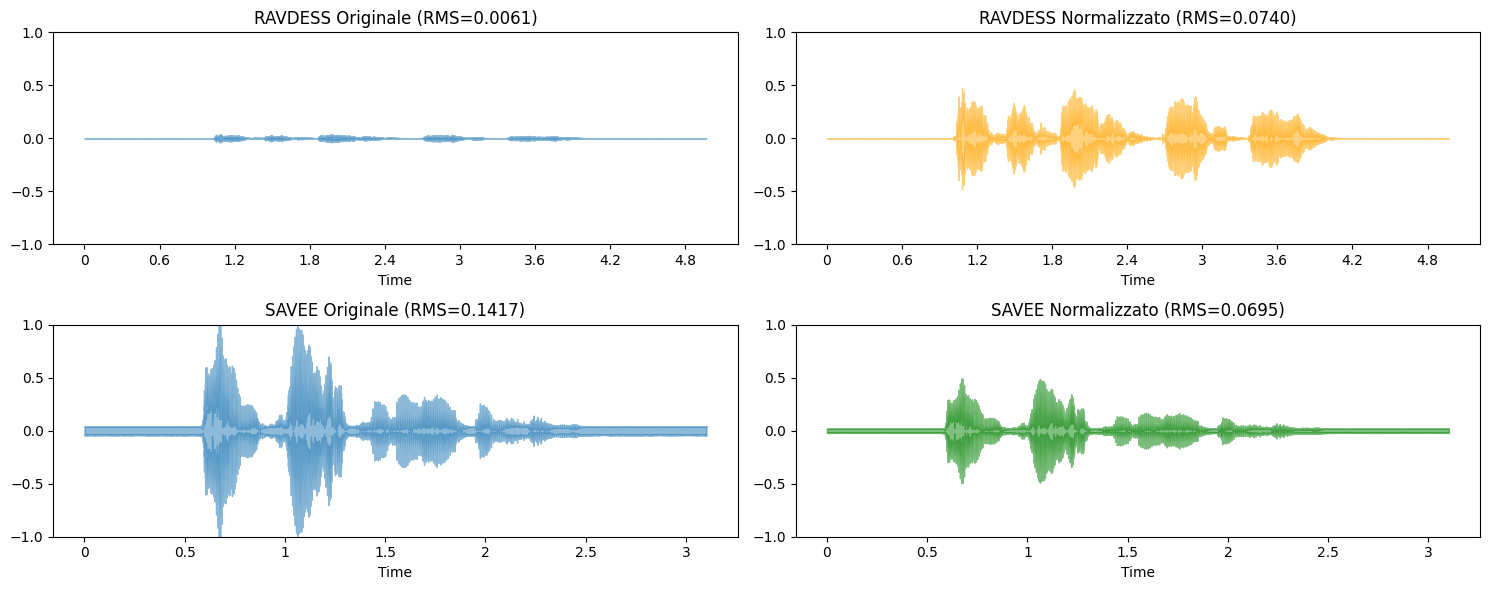

In [ ]:
def normalize_volume(y, target_rms = 0.05):
    rms = librosa.feature.rms(y=y)
    current_rms = np.mean(rms)
    
    if current_rms < 1e-5:
        return y
    
    gain = target_rms / current_rms
    y_norm = y * gain
    
    y_norm = np.clip(y_norm, -1.0, 1.0) #truncate to avoid clipping
    return y_norm

try:

    file_low_volume = df[df["source"] == "ravdess"]["file"].iloc[47]
    file_high_volume = df[df["source"] == "savee"]["file"].iloc[47]

    y_low, _ = librosa.load(file_low_volume, sr=16000)
    y_high, _ = librosa.load(file_high_volume, sr=16000)
    
    y_low_norm = normalize_volume(y_low, target_rms=0.05)
    y_high_norm = normalize_volume(y_high, target_rms=0.05)
    
    plt.figure(figsize=(15, 6))

    plt.subplot(2, 2, 1)
    librosa.display.waveshow(y_low, sr=16000, alpha=0.5)
    plt.title(f"RAVDESS Originale (RMS={np.sqrt(np.mean(y_low**2)):.4f})")
    plt.ylim(-1, 1)

    plt.subplot(2, 2, 2)
    librosa.display.waveshow(y_low_norm, sr=16000, color='orange', alpha=0.5)
    plt.title(f"RAVDESS Normalizzato (RMS={np.sqrt(np.mean(y_low_norm**2)):.4f})")
    plt.ylim(-1, 1)

    plt.subplot(2, 2, 3)
    librosa.display.waveshow(y_high, sr=16000, alpha=0.5)
    plt.title(f"SAVEE Originale (RMS={np.sqrt(np.mean(y_high**2)):.4f})")
    plt.ylim(-1, 1)

    plt.subplot(2, 2, 4)
    librosa.display.waveshow(y_high_norm, sr=16000, color='green', alpha=0.5)
    plt.title(f"SAVEE Normalizzato (RMS={np.sqrt(np.mean(y_high_norm**2)):.4f})")
    plt.ylim(-1, 1)

    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error processing files: {e}") 
    
    
    

In [17]:
def calculate_energy_normalized(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        
        y_norm = normalize_volume(y, target_rms=0.05)
        rms = librosa.feature.rms(y=y_norm)
        energy_norm = np.mean(rms)
        return energy_norm
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

df['energy_norm'] = df['file'].apply(calculate_energy_normalized)  
df.energy_norm.isna().any()

np.False_

In [18]:
df.energy_norm.describe()

count    10678.000000
mean         0.049988
std          0.000169
min          0.042631
25%          0.050000
50%          0.050000
75%          0.050000
max          0.050000
Name: energy_norm, dtype: float64

#### Testing normalized samples...

In [20]:
import soundfile as sf

In [21]:
df.source.value_counts()

source
emoita     5674
tess       2800
ravdess    1724
savee       480
Name: count, dtype: int64

In [22]:
def create_normalized_samples(sample_number):
    
    source_low = ["ravdess", "tess"]
    source_high = ["emoita", "savee"]
    
    try:
        
        rand_source_low = np.random.choice(source_low)
        rand_source_high = np.random.choice(source_high)

        file_low_volume = df[df["source"] == rand_source_low]["file"].iloc[sample_number]
        file_high_volume = df[df["source"] == rand_source_high]["file"].iloc[sample_number]

        y_low, _ = librosa.load(file_low_volume, sr=16000)
        y_high, _ = librosa.load(file_high_volume, sr=16000)

        rms_selected = 0.05
        y_low_norm = normalize_volume(y_low, target_rms=rms_selected)
        y_high_norm = normalize_volume(y_high, target_rms=rms_selected)

        output_dir = "normalized_samples"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        else:
            print(f"Directory {output_dir} already exists.")

        sf.write(os.path.join(output_dir, f"{rand_source_low}_low-{sample_number}.wav"), y_low, 16000)    
        sf.write(os.path.join(output_dir, f"{rand_source_low}_low_norm-{sample_number}.wav"), y_low_norm, 16000)

        sf.write(os.path.join(output_dir, f"{rand_source_high}_high-{sample_number}.wav"), y_high, 16000)    
        sf.write(os.path.join(output_dir, f"{rand_source_high}_high_norm-{sample_number}.wav"), y_high_norm, 16000)
    except Exception as e:
        print(f"Error processing files: {e}")

In [23]:
sample_number = random.randint(0, 479)

create_normalized_samples(sample_number)

Directory normalized_samples already exists.


<Figure size 1400x600 with 0 Axes>

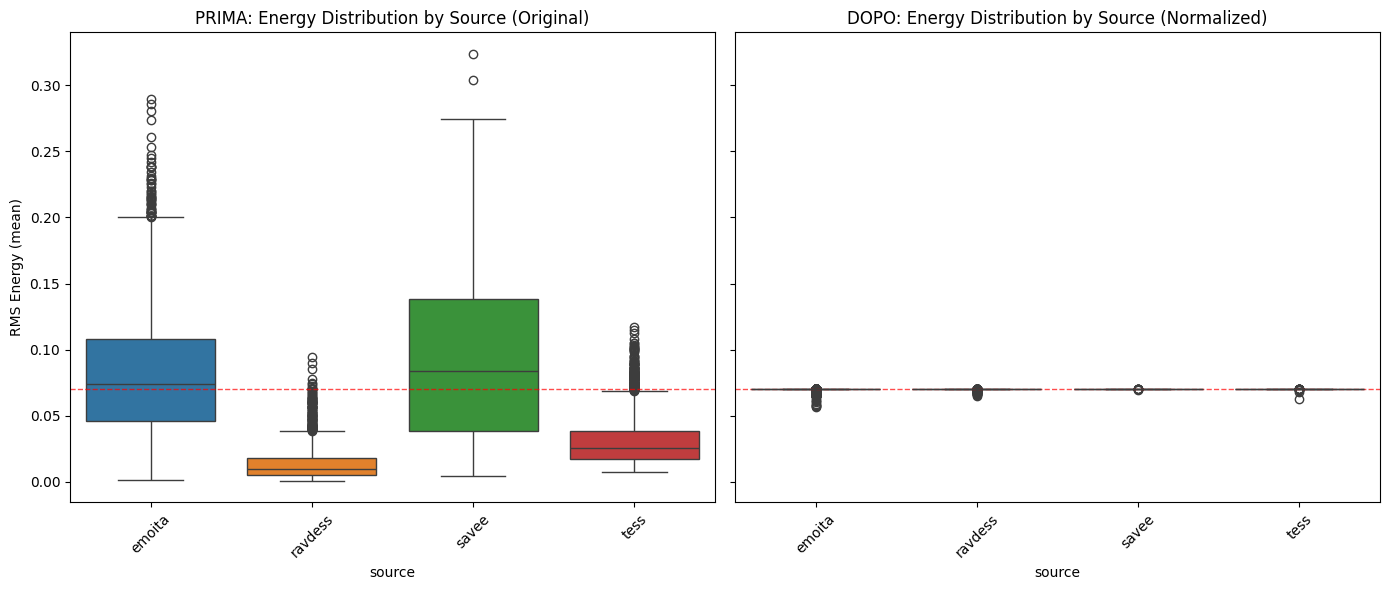

In [24]:
def calculate_energy_normalized(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)

        y_norm = normalize_volume(y, target_rms=0.07)
        rms = librosa.feature.rms(y=y_norm)
        energy_norm = np.mean(rms)
        return energy_norm
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

df['energy_norm'] = df['file'].apply(calculate_energy_normalized)  
df.energy_norm.isna().any()

plt.figure(figsize=(14, 6))

# Creiamo i subplot definendo SUBITO che condividono l'asse Y
# Questo forza entrambi i grafici ad avere la stessa scala verticale (es. da 0.0 a 0.35)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- PLOT 1: Originale ---
sns.boxplot(x='source', y='energy', data=df, hue='source', ax=axes[0], legend=False)
axes[0].set_title('PRIMA: Energy Distribution by Source (Original)')
axes[0].set_ylabel('RMS Energy (mean)')
axes[0].tick_params(axis='x', rotation=45)

# --- PLOT 2: Normalizzato ---
sns.boxplot(x='source', y='energy_norm', data=df, hue='source', ax=axes[1], legend=False)
axes[1].set_title('DOPO: Energy Distribution by Source (Normalized)')
axes[1].set_ylabel('') # Rimuoviamo la label Y perché è ridondante
axes[1].tick_params(axis='x', rotation=45)

# Aggiungiamo una linea rossa di riferimento sul target (0.05) su entrambi i grafici
axes[0].axhline(y=0.07, color='red', linestyle='--', linewidth=1, alpha=0.7)
axes[1].axhline(y=0.07, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.tight_layout()
plt.show()

([0, 1, 2, 3],
 [Text(0, 0, 'emoita'),
  Text(1, 0, 'ravdess'),
  Text(2, 0, 'savee'),
  Text(3, 0, 'tess')])

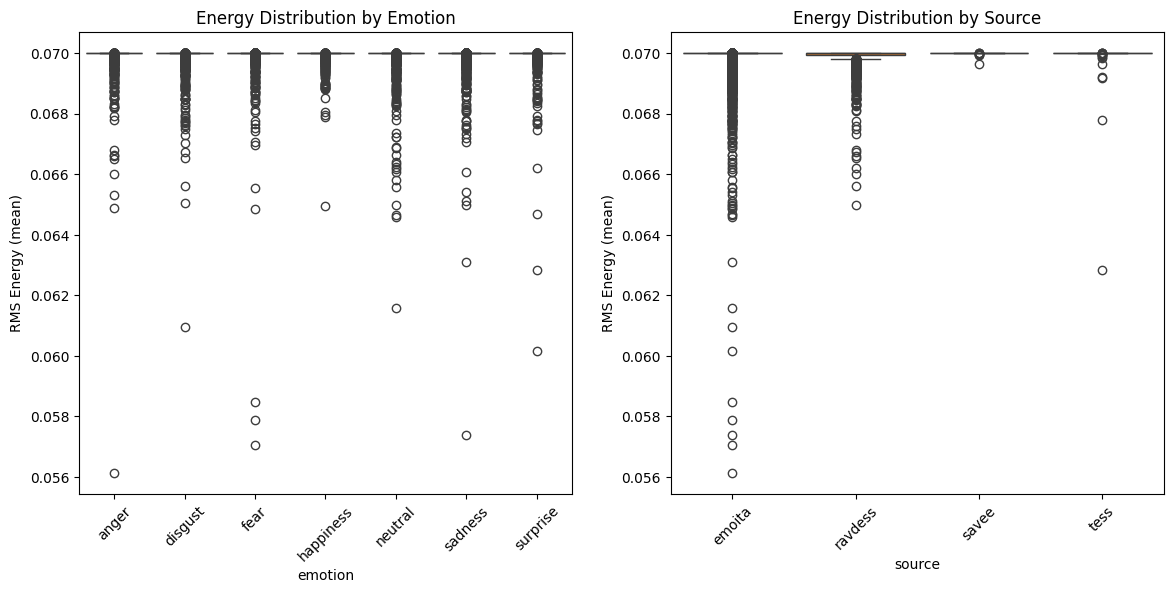

In [38]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='emotion', y='energy_norm', data=df, hue='emotion')
plt.title('Energy Distribution by Emotion')
plt.ylabel('RMS Energy (mean)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='source', y='energy_norm', data=df, hue='source')
plt.title('Energy Distribution by Source')
plt.ylabel('RMS Energy (mean)')
plt.xticks(rotation=45)


### Peak Normalization

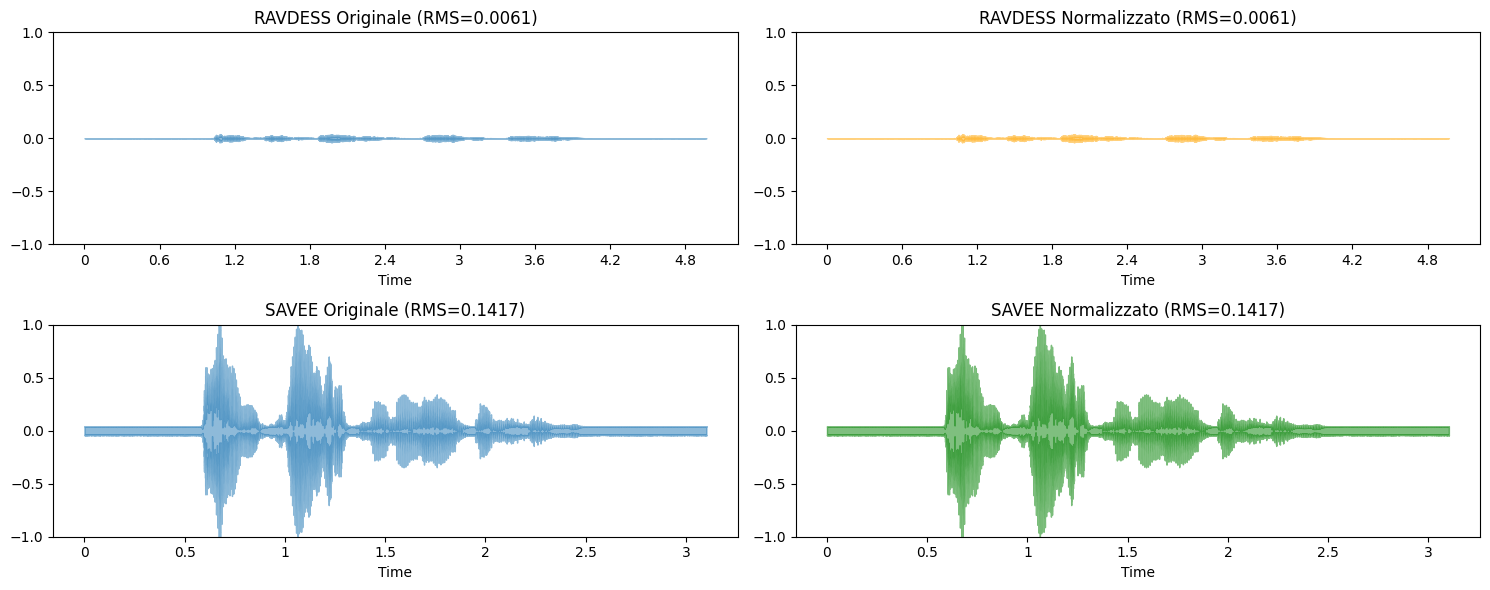

In [39]:
def peak_normalization(y, target_level = 0.95):
    
    peak = np.max(np.abs(y))
    
    if peak < 1e5:
        return y
    
    y_norm = y / peak * target_level
    
    return y_norm

try:

    file_low_volume = df[df["source"] == "ravdess"]["file"].iloc[47]
    file_high_volume = df[df["source"] == "savee"]["file"].iloc[47]

    y_low, _ = librosa.load(file_low_volume, sr=16000)
    y_high, _ = librosa.load(file_high_volume, sr=16000)
    
    y_low_norm = peak_normalization(y_low)
    y_high_norm = peak_normalization(y_high)
    
    plt.figure(figsize=(15, 6))

    plt.subplot(2, 2, 1)
    librosa.display.waveshow(y_low, sr=16000, alpha=0.5)
    plt.title(f"RAVDESS Originale (RMS={np.sqrt(np.mean(y_low**2)):.4f})")
    plt.ylim(-1, 1)

    plt.subplot(2, 2, 2)
    librosa.display.waveshow(y_low_norm, sr=16000, color='orange', alpha=0.5)
    plt.title(f"RAVDESS Normalizzato (RMS={np.sqrt(np.mean(y_low_norm**2)):.4f})")
    plt.ylim(-1, 1)

    plt.subplot(2, 2, 3)
    librosa.display.waveshow(y_high, sr=16000, alpha=0.5)
    plt.title(f"SAVEE Originale (RMS={np.sqrt(np.mean(y_high**2)):.4f})")
    plt.ylim(-1, 1)

    plt.subplot(2, 2, 4)
    librosa.display.waveshow(y_high_norm, sr=16000, color='green', alpha=0.5)
    plt.title(f"SAVEE Normalizzato (RMS={np.sqrt(np.mean(y_high_norm**2)):.4f})")
    plt.ylim(-1, 1)

    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error processing files: {e}") 
    
    
    

<Figure size 1400x600 with 0 Axes>

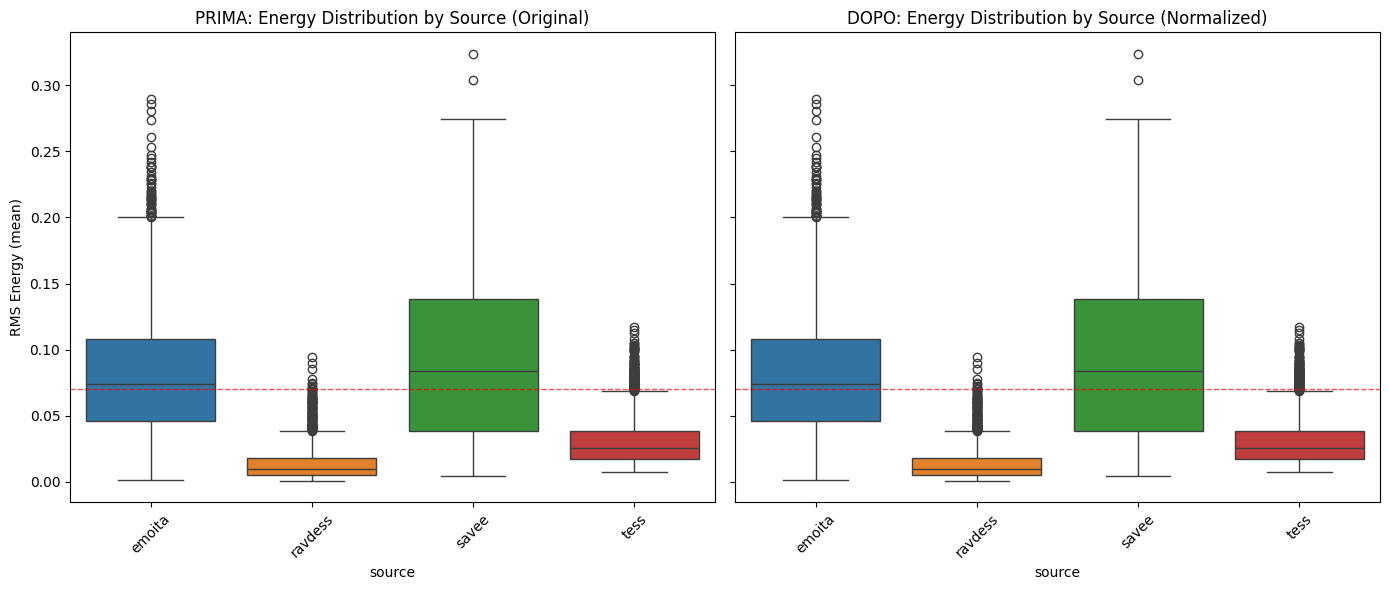

In [41]:
def calculate_energy_normalized(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)

        y_norm = peak_normalization(y)
        rms = librosa.feature.rms(y=y_norm)
        energy_norm = np.mean(rms)
        return energy_norm
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

df['energy_norm'] = df['file'].apply(calculate_energy_normalized)  
df.energy_norm.isna().any()

plt.figure(figsize=(14, 6))

# Creiamo i subplot definendo SUBITO che condividono l'asse Y
# Questo forza entrambi i grafici ad avere la stessa scala verticale (es. da 0.0 a 0.35)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- PLOT 1: Originale ---
sns.boxplot(x='source', y='energy', data=df, hue='source', ax=axes[0], legend=False)
axes[0].set_title('PRIMA: Energy Distribution by Source (Original)')
axes[0].set_ylabel('RMS Energy (mean)')
axes[0].tick_params(axis='x', rotation=45)

# --- PLOT 2: Normalizzato ---
sns.boxplot(x='source', y='energy_norm', data=df, hue='source', ax=axes[1], legend=False)
axes[1].set_title('DOPO: Energy Distribution by Source (Normalized)')
axes[1].set_ylabel('') # Rimuoviamo la label Y perché è ridondante
axes[1].tick_params(axis='x', rotation=45)

# Aggiungiamo una linea rossa di riferimento sul target (0.05) su entrambi i grafici
axes[0].axhline(y=0.07, color='red', linestyle='--', linewidth=1, alpha=0.7)
axes[1].axhline(y=0.07, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.tight_layout()
plt.show()

### LUFS Normalization

In [42]:
import pyloudnorm as pyln

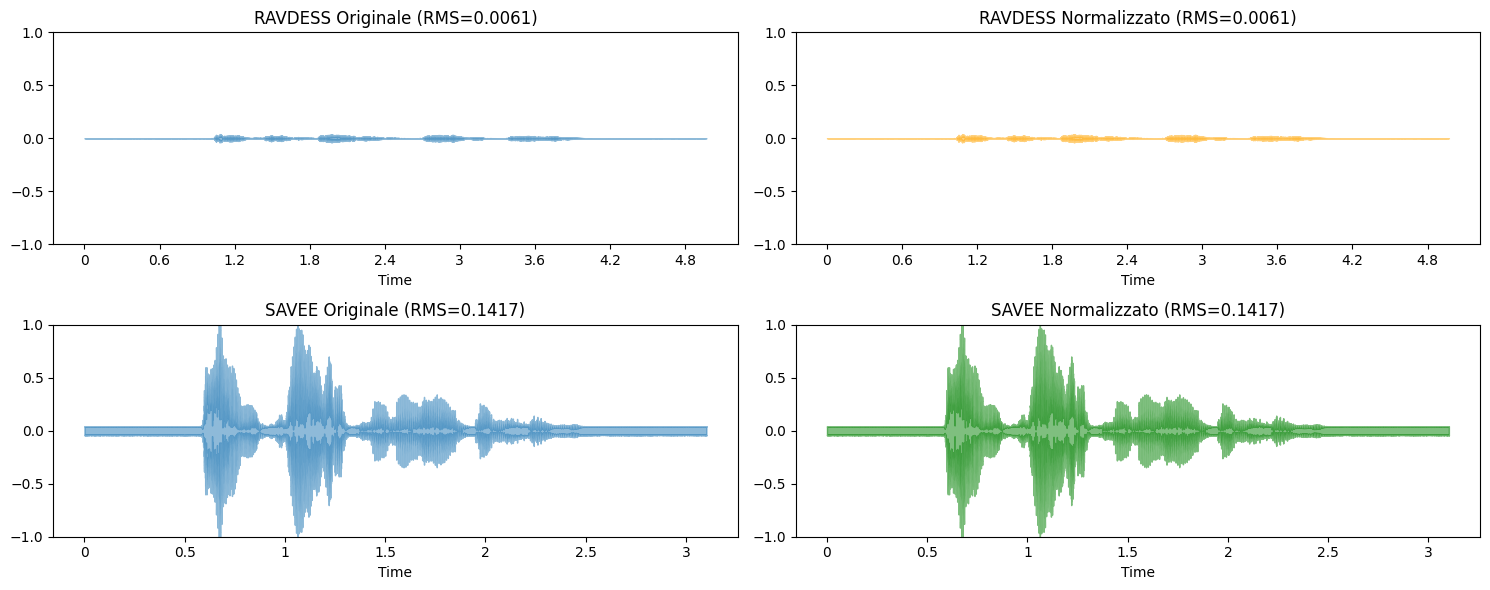

In [48]:
def lufs_normalization(y, sr = 16000, target_lufs = -23.0):
    
    if np.max(np.abs(y)) < 1e5:
        return y
    try:
        meter = pyln.Meter(sr)
        current_lufs = meter.integrated_loudness(y)
        
        y_norm = pyln.normalize.loudness(y, current_lufs, target_lufs)
        return y_norm
    except Exception as e:
        print(f'{e}')
        return y

try:

    file_low_volume = df[df["source"] == "ravdess"]["file"].iloc[47]
    file_high_volume = df[df["source"] == "savee"]["file"].iloc[47]

    y_low, _ = librosa.load(file_low_volume, sr=16000)
    y_high, _ = librosa.load(file_high_volume, sr=16000)
    
    y_low_norm = lufs_normalization(y_low)
    y_high_norm = lufs_normalization(y_high)
    
    plt.figure(figsize=(15, 6))

    plt.subplot(2, 2, 1)
    librosa.display.waveshow(y_low, sr=16000, alpha=0.5)
    plt.title(f"RAVDESS Originale (RMS={np.sqrt(np.mean(y_low**2)):.4f})")
    plt.ylim(-1, 1)

    plt.subplot(2, 2, 2)
    librosa.display.waveshow(y_low_norm, sr=16000, color='orange', alpha=0.5)
    plt.title(f"RAVDESS Normalizzato (RMS={np.sqrt(np.mean(y_low_norm**2)):.4f})")
    plt.ylim(-1, 1)

    plt.subplot(2, 2, 3)
    librosa.display.waveshow(y_high, sr=16000, alpha=0.5)
    plt.title(f"SAVEE Originale (RMS={np.sqrt(np.mean(y_high**2)):.4f})")
    plt.ylim(-1, 1)

    plt.subplot(2, 2, 4)
    librosa.display.waveshow(y_high_norm, sr=16000, color='green', alpha=0.5)
    plt.title(f"SAVEE Normalizzato (RMS={np.sqrt(np.mean(y_high_norm**2)):.4f})")
    plt.ylim(-1, 1)

    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error processing files: {e}") 
    
    
    

<Figure size 1400x600 with 0 Axes>

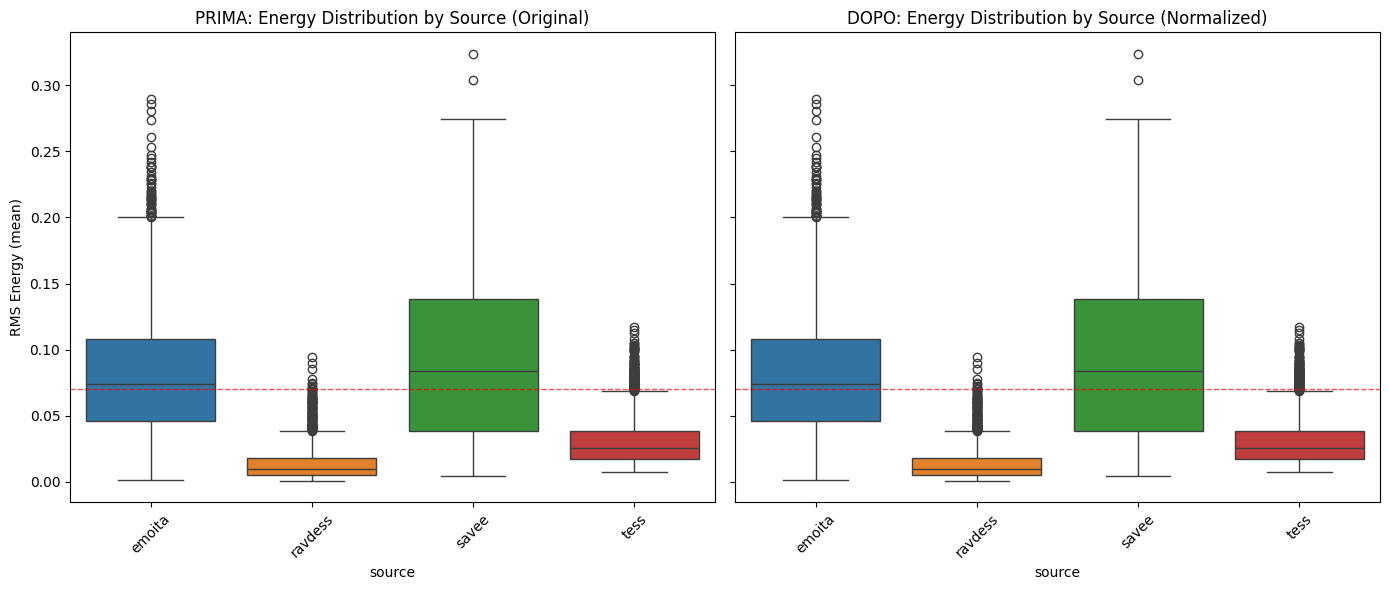

In [49]:
def calculate_energy_normalized(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)

        y_norm = lufs_normalization(y)
        rms = librosa.feature.rms(y=y_norm)
        energy_norm = np.mean(rms)
        return energy_norm
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

df['energy_norm'] = df['file'].apply(calculate_energy_normalized)  
df.energy_norm.isna().any()

plt.figure(figsize=(14, 6))

# Creiamo i subplot definendo SUBITO che condividono l'asse Y
# Questo forza entrambi i grafici ad avere la stessa scala verticale (es. da 0.0 a 0.35)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- PLOT 1: Originale ---
sns.boxplot(x='source', y='energy', data=df, hue='source', ax=axes[0], legend=False)
axes[0].set_title('PRIMA: Energy Distribution by Source (Original)')
axes[0].set_ylabel('RMS Energy (mean)')
axes[0].tick_params(axis='x', rotation=45)

# --- PLOT 2: Normalizzato ---
sns.boxplot(x='source', y='energy_norm', data=df, hue='source', ax=axes[1], legend=False)
axes[1].set_title('DOPO: Energy Distribution by Source (Normalized)')
axes[1].set_ylabel('') # Rimuoviamo la label Y perché è ridondante
axes[1].tick_params(axis='x', rotation=45)

# Aggiungiamo una linea rossa di riferimento sul target (0.05) su entrambi i grafici
axes[0].axhline(y=0.07, color='red', linestyle='--', linewidth=1, alpha=0.7)
axes[1].axhline(y=0.07, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.tight_layout()
plt.show()

In [50]:
def create_normalized_samples(sample_number):
    
    source_low = ["ravdess", "tess"]
    source_high = ["emoita", "savee"]
    
    try:
        
        rand_source_low = np.random.choice(source_low)
        rand_source_high = np.random.choice(source_high)

        file_low_volume = df[df["source"] == rand_source_low]["file"].iloc[sample_number]
        file_high_volume = df[df["source"] == rand_source_high]["file"].iloc[sample_number]

        y_low, _ = librosa.load(file_low_volume, sr=16000)
        y_high, _ = librosa.load(file_high_volume, sr=16000)

        rms_selected = 0.05
        y_low_norm = lufs_normalization(y_low)
        y_high_norm = lufs_normalization(y_high)

        output_dir = "normalized_samples"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        else:
            print(f"Directory {output_dir} already exists.")

        sf.write(os.path.join(output_dir, f"{rand_source_low}_low-{sample_number}.wav"), y_low, 16000)    
        sf.write(os.path.join(output_dir, f"{rand_source_low}_low_norm-{sample_number}.wav"), y_low_norm, 16000)

        sf.write(os.path.join(output_dir, f"{rand_source_high}_high-{sample_number}.wav"), y_high, 16000)    
        sf.write(os.path.join(output_dir, f"{rand_source_high}_high_norm-{sample_number}.wav"), y_high_norm, 16000)
    except Exception as e:
        print(f"Error processing files: {e}")

In [52]:
sample_number = random.randint(0, 479)

create_normalized_samples(sample_number)

Directory normalized_samples already exists.


([0, 1, 2, 3],
 [Text(0, 0, 'emoita'),
  Text(1, 0, 'ravdess'),
  Text(2, 0, 'savee'),
  Text(3, 0, 'tess')])

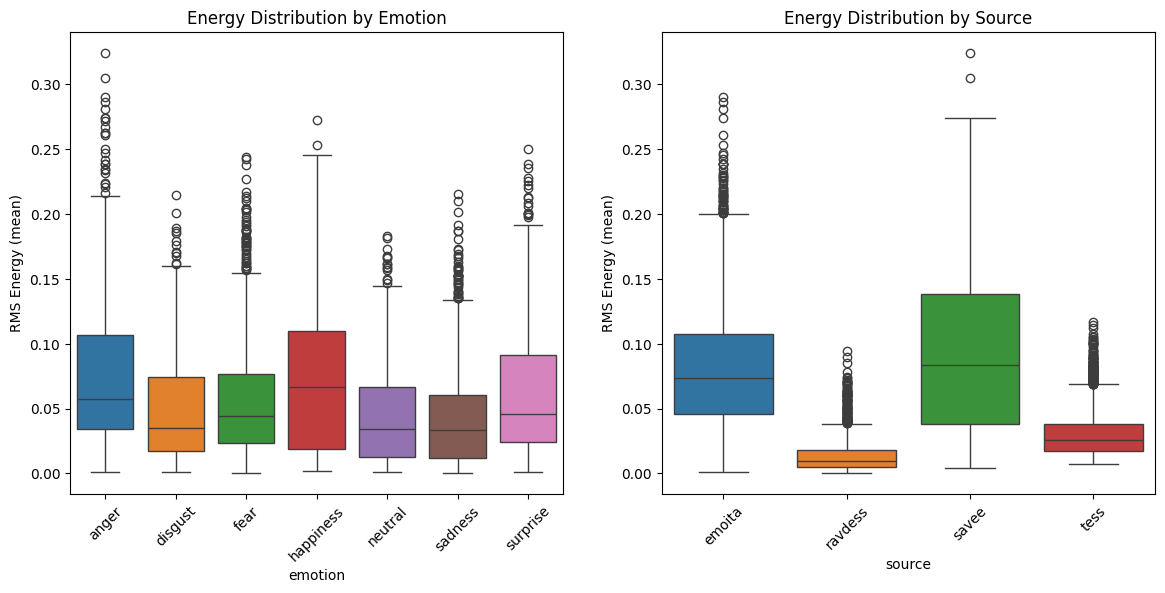

In [47]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='emotion', y='energy_norm', data=df, hue='emotion')
plt.title('Energy Distribution by Emotion')
plt.ylabel('RMS Energy (mean)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='source', y='energy_norm', data=df, hue='source')
plt.title('Energy Distribution by Source')
plt.ylabel('RMS Energy (mean)')
plt.xticks(rotation=45)


### Silence Ratio

In [25]:
def extract_silence_ratio(file_path, top_db=30):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        
        y_norm = normalize_volume(y, target_rms=0.07)

        intervals = librosa.effects.split(y_norm, top_db=top_db)
        non_silent_samples = 0
        for interval in intervals:
            non_silent_samples += (interval[1] - interval[0])
            
        total_samples = len(y_norm)
        if total_samples == 0:
            return np.nan
        
        silent_ratio = 1 - (non_silent_samples / total_samples)
        return silent_ratio
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

df["silence_ratio"] = df["file"].apply(extract_silence_ratio)
print(df.silence_ratio.isna().any())
print(df.silence_ratio.describe())

False
count    10678.000000
mean         0.239182
std          0.185943
min          0.000000
25%          0.054852
50%          0.225432
75%          0.403801
max          0.843436
Name: silence_ratio, dtype: float64


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'anger'),
  Text(1, 0, 'disgust'),
  Text(2, 0, 'fear'),
  Text(3, 0, 'happiness'),
  Text(4, 0, 'neutral'),
  Text(5, 0, 'sadness'),
  Text(6, 0, 'surprise')])

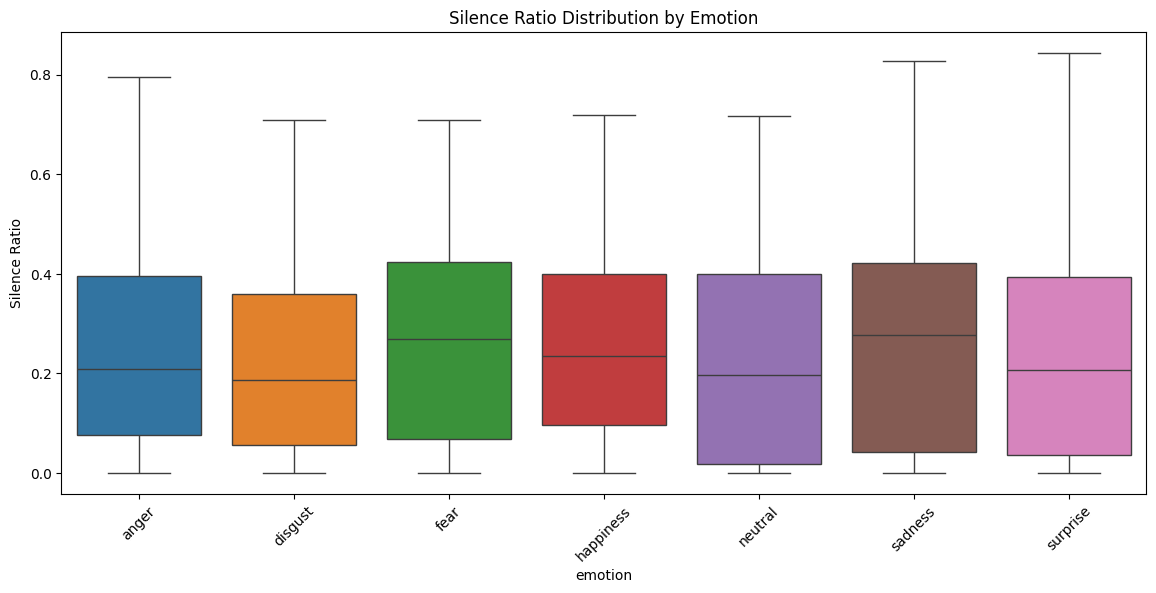

In [26]:
plt.figure(figsize=(14, 6))

sns.boxplot(x='emotion', y='silence_ratio', data=df, hue='emotion')
plt.title('Silence Ratio Distribution by Emotion')
plt.ylabel('Silence Ratio')
plt.xticks(rotation=45)


## FEATURES EXTRACTION

In [27]:
def normalize_volume(y, target_rms = 0.05):
    rms = librosa.feature.rms(y=y)
    current_rms = np.mean(rms)
    
    if current_rms < 1e-5:
        return y
    
    gain = target_rms / current_rms
    y_norm = y * gain
    
    y_norm = np.clip(y_norm, -1.0, 1.0) #truncate to avoid clipping
    return y_norm

In [28]:
# Function to compute mean and std for each feature, returning a dictionary of statistics of each feature
def compute_mean_and_std(feature_matrix, prefix):
    
    stats = {}
    mean = np.mean(feature_matrix, axis=1)
    std = np.std(feature_matrix, axis=1)
    
    for i, (m, s) in enumerate(zip(mean, std)):
        stats[f"{prefix}_mean_{i+1}"] = m
        stats[f"{prefix}_std_{i+1}"] = s
        
    return stats

#### Prosodic Features

In [29]:
# RMS Energy as proxy of loudness
def get_rms(y)-> dict:
    rms = librosa.feature.rms(y=y)
    return compute_mean_and_std(rms, "rms")

# Zero Crossing Rate as proxy of Arousal
def get_zcr(y)-> dict:
    zcr = librosa.feature.zero_crossing_rate(y=y)
    return compute_mean_and_std(zcr, "zcr")

#### Timbro vocale

In [30]:
# MFCC for spectral characteristics
def get_mfcc(y, rs = 16000, n_mfcc = 13)-> dict:
    mfcc = librosa.feature.mfcc(y=y, sr=rs, n_mfcc=n_mfcc)
    return compute_mean_and_std(mfcc, "mfcc")

#Delta MFCC for temporal dynamics
def get_delta_mfcc(y, rs = 16000, n_mfcc = 13)-> dict:
    mfcc = librosa.feature.mfcc(y=y, sr=rs, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    return compute_mean_and_std(delta_mfcc, "delta_mfcc")

#Delta-Delta MFCC for acceleration characteristics
def get_delta2_mfcc(y, rs = 16000, n_mfcc = 13)-> dict:
    mfcc = librosa.feature.mfcc(y=y, sr=rs, n_mfcc=n_mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    return compute_mean_and_std(delta2_mfcc, "delta2_mfcc")


In [31]:
# Spectral contrast for timbral texture
def get_spectral_contrast(y, rs = 16000)-> dict:
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=rs)
    return compute_mean_and_std(spectral_contrast, "spectral_contrast")

#### Tonal Features

In [32]:
# Chroma features for harmonic content
def get_chroma(y, rs = 16000)-> dict:
    chroma = librosa.feature.chroma_stft(y=y, sr=rs)
    return compute_mean_and_std(chroma, "chroma")

# Tonnetz for tonal characteristics
def get_tonnetz(y, rs = 16000)-> dict:
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=rs)
    return compute_mean_and_std(tonnetz, "tonnetz")

In [33]:
sample, sr = librosa.load("normalized_samples/emoita_high_norm-27.wav", sr=16000)

In [34]:
get_mfcc(sample)

{'mfcc_mean_1': np.float32(-279.19382),
 'mfcc_std_1': np.float32(163.48645),
 'mfcc_mean_2': np.float32(66.13817),
 'mfcc_std_2': np.float32(41.859962),
 'mfcc_mean_3': np.float32(-3.0647645),
 'mfcc_std_3': np.float32(33.35815),
 'mfcc_mean_4': np.float32(11.701006),
 'mfcc_std_4': np.float32(22.501326),
 'mfcc_mean_5': np.float32(-20.40056),
 'mfcc_std_5': np.float32(24.997227),
 'mfcc_mean_6': np.float32(1.178453),
 'mfcc_std_6': np.float32(14.320435),
 'mfcc_mean_7': np.float32(-10.098258),
 'mfcc_std_7': np.float32(21.160673),
 'mfcc_mean_8': np.float32(1.9810091),
 'mfcc_std_8': np.float32(9.709387),
 'mfcc_mean_9': np.float32(-18.229986),
 'mfcc_std_9': np.float32(15.148194),
 'mfcc_mean_10': np.float32(-3.724227),
 'mfcc_std_10': np.float32(10.216469),
 'mfcc_mean_11': np.float32(-30.354973),
 'mfcc_std_11': np.float32(18.311945),
 'mfcc_mean_12': np.float32(4.161553),
 'mfcc_std_12': np.float32(10.612561),
 'mfcc_mean_13': np.float32(-20.184313),
 'mfcc_std_13': np.float32(12

In [35]:

def get_prosodic_features(y):
    features = {}
    
    # --- RMS Energy ---
    rms = librosa.feature.rms(y=y)
    # RMS è (1, T), quindi prendiamo direttamente mean e std scalari
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)
    
    # --- Zero Crossing Rate ---
    zcr = librosa.feature.zero_crossing_rate(y=y)
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)
    
    return features

In [36]:
get_prosodic_features(sample)

{'rms_mean': np.float32(0.050000537),
 'rms_std': np.float32(0.03302247),
 'zcr_mean': np.float64(0.13634095574817517),
 'zcr_std': np.float64(0.09497086562019798)}

In [37]:
RS = 16000
TARGET_RMS = 0.06

def load_and_normalize(file, target_rms = TARGET_RMS):
    
    y, sr = librosa.load(file, sr=RS)
    
    rms = librosa.feature.rms(y=y)
    current_rms = np.mean(rms)
    
    if current_rms < 1e-5:
        return y
    
    gain = target_rms / current_rms
    y_norm = y * gain
    
    y_norm = np.clip(y_norm, -1.0, 1.0) #truncate to avoid clipping
    return y_norm

def extract_features(row):
    
    file = row["file"]
    y = load_and_normalize(file)
    
    if y is None or len(y) < 2048:
        return None
    
    full_vector = {}
    
    full_vector["file"] = file
    full_vector["label"] = row["emotion"]
    full_vector["split"] = row["split"]
    
    try:
        full_vector.update(get_rms(y))
        full_vector.update(get_zcr(y))
        full_vector.update(get_mfcc(y))
        full_vector.update(get_delta_mfcc(y))
        full_vector.update(get_delta2_mfcc(y))
        full_vector.update(get_spectral_contrast(y))
        full_vector.update(get_chroma(y))
        full_vector.update(get_tonnetz(y))
        return full_vector
    except Exception as e:
        print(f"Extraction failed for {file}: {e}")
        return None 

In [ ]:
if __name__ == "__main__":
    
    features_list = list()
    
    for i, row in tqdm(df.iterrows(), total = df.shape[0]):
        
        features_vector = extract_features(row)
        
        if features_vector is not None:
            features_list.append(features_vector)
            
    FULL_df_new = pd.DataFrame(features_list)
    

  3%|▎         | 359/10678 [00:39<19:10,  8.97it/s]/Users/alfred/Documents/SER/.venv/lib/python3.14/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=500
  warnings.warn(
  4%|▎         | 385/10678 [00:42<19:49,  8.65it/s]/Users/alfred/Documents/SER/.venv/lib/python3.14/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=404
  warnings.warn(
  4%|▎         | 390/10678 [00:43<19:08,  8.95it/s]/Users/alfred/Documents/SER/.venv/lib/python3.14/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=468
  warnings.warn(
  4%|▍         | 410/10678 [00:45<18:29,  9.26it/s]/Users/alfred/Documents/SER/.venv/lib/python3.14/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=462
  warnings.warn(
  4%|▍         | 423/10678 [00:47<20:17,  8.42it/s]/Users/alfred/Documents/SER/.venv/lib

In [ ]:
FULL_df_new

In [ ]:
output_dir = "TRAINING_ML"

if os.path.exists(output_dir):
    print("Directory already exists")
else:
    os.mkdir(output_dir)
    
# out_path = os.path.join(output_dir, "FULL_TRAINING.pkl")

FULL_df_new.to_pickle(out_path)